
## Flash Flood Study Exploratory Data Analysis (EDA)

In [1]:
%pylab inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import glob
import sklearn.ensemble as ens
from sklearn.model_selection import train_test_split
from sklearn import metrics
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/Users/nicholascarr/anaconda/envs/flood/lib/python2.7/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
def plot_heatmap(df, site_name):

    f, ax = plt.subplots(figsize=(16, 12))
    plt.title('Correlations between predictors for {}'.format(site_name),
              fontweight='bold', fontsize=16)
    corr = df.corr()
    ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
    plt.savefig('Heatmap{}'.format(site_name))


def importance_plot(predictors, feature_importances, site_name):
    
    labels = feature_imp.index.tolist()
    indices = np.argsort(feature_imp)[::-1]
    plt.figure(figsize=(22,10))
    plt.title("Feature importances for {}".format(site_name),
              fontweight='bold', fontsize=20)
    plt.bar(range(predictors.shape[1]), feature_imp[indices],
            color="r", align="center")
    plt.xticks(range(predictors.shape[1]), labels, fontweight='bold', fontsize=7.7)
    plt.xlim([-1, predictors.shape[1]])
    plt.savefig('Feature_Imp{}'.format(site_name))
    

def boxplot(df, feature_imp, site_name, n_features=6):
    if n_features %2 != 0:
        raise ValueError('Must be even number of features')
    df['Text_Result'] = np.nan
    df.loc[(df.Result == 0), 'Text_Result'] = 'No Flooding'
    df.loc[(df.Result == 1), 'Text_Result'] = 'Widespread Flooding'
    fix, axes = plt.subplots ((n_features / 2), 2, figsize=(16,16))
    plt.suptitle('Boxplot for {}'.format(site_name), fontweight='bold', fontsize=18)
    axs = axes.ravel()

    #Only plot 8 most important features
    for i, feature in enumerate(feature_imp.index[:n_features]):
        boxplot = sns.boxplot(x='Text_Result', y=feature, data=df, width=0.5, 
                              order= ['No Flooding', 'Widespread Flooding'], ax=axs[i])
        plt.savefig('boxplot{}'.format(site_name))

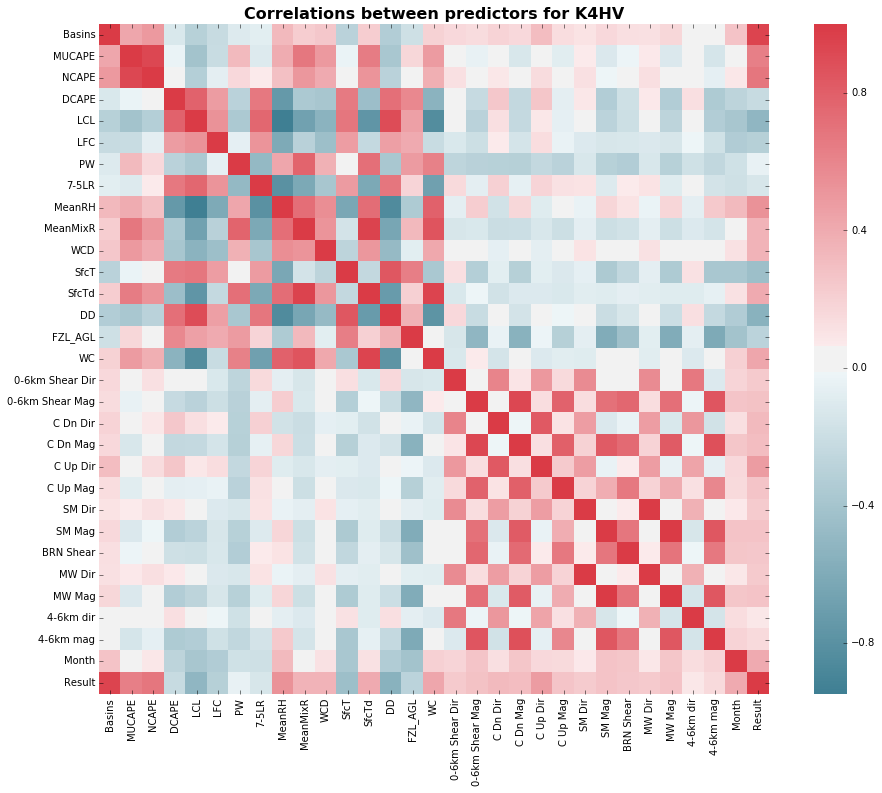

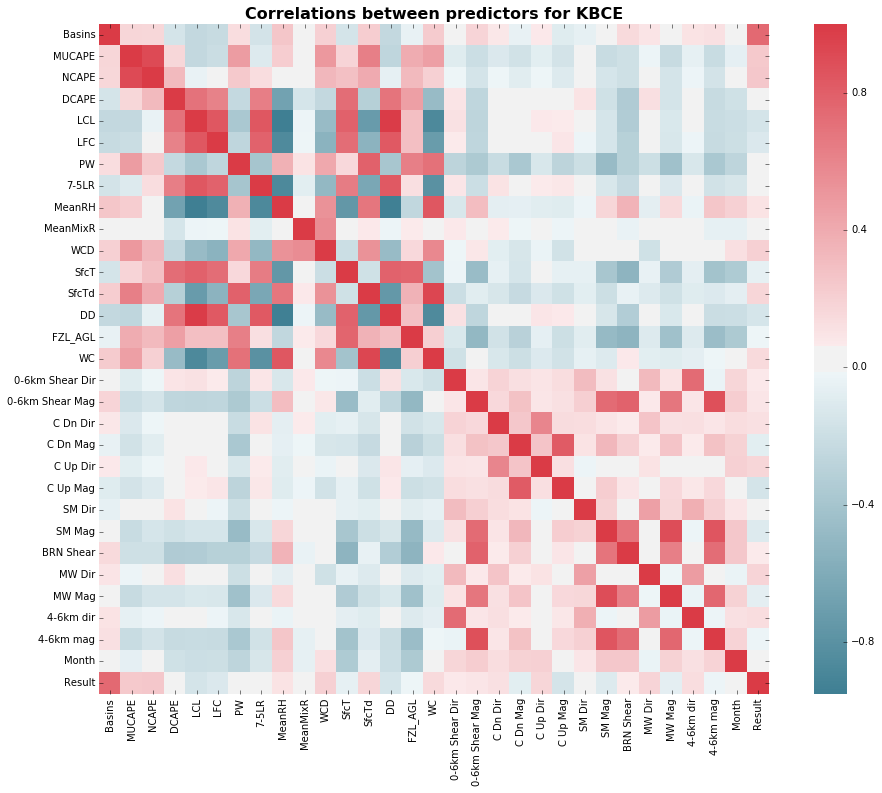

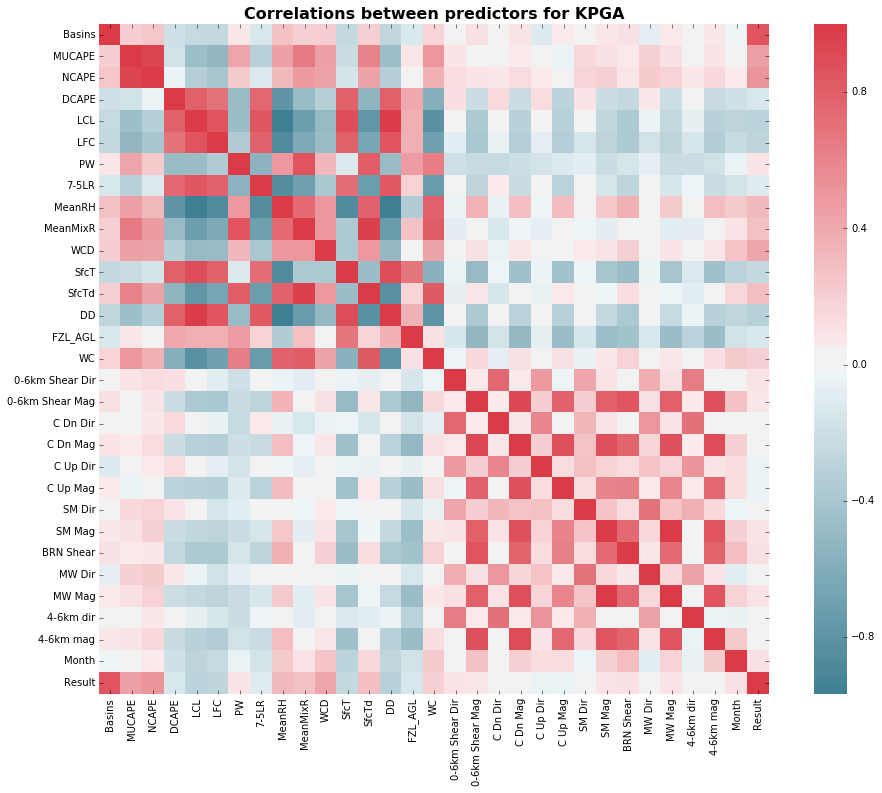

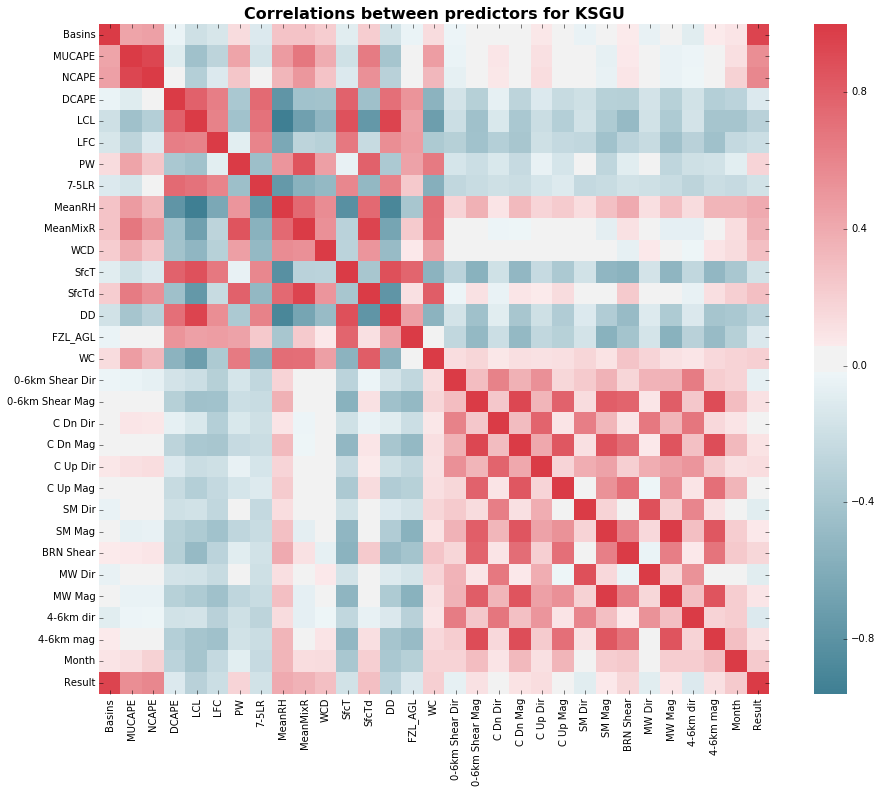

In [3]:
for csv in glob.glob("*clean.csv"):
    site_name = csv[:4]
    df = pd.read_csv(csv)
    plot_heatmap(df, site_name)

('K4HV', 'Accuracy = 0.80,  Brier Score 0.14, Out of bag error score 0.17')


,No Flooding Forecast,Flooding Forecast
No Flooding Observed,6,2
Flooding Observed,1,6


------------------------------------ 

('KBCE', 'Accuracy = 0.70,  Brier Score 0.21, Out of bag error score 0.26')


,No Flooding Forecast,Flooding Forecast
No Flooding Observed,3,12
Flooding Observed,1,28


------------------------------------ 

('KPGA', 'Accuracy = 0.79,  Brier Score 0.14, Out of bag error score 0.31')


,No Flooding Forecast,Flooding Forecast
No Flooding Observed,6,4
Flooding Observed,2,16


------------------------------------ 

('KSGU', 'Accuracy = 0.74,  Brier Score 0.19, Out of bag error score 0.28')


,No Flooding Forecast,Flooding Forecast
No Flooding Observed,4,5
Flooding Observed,0,10


------------------------------------ 



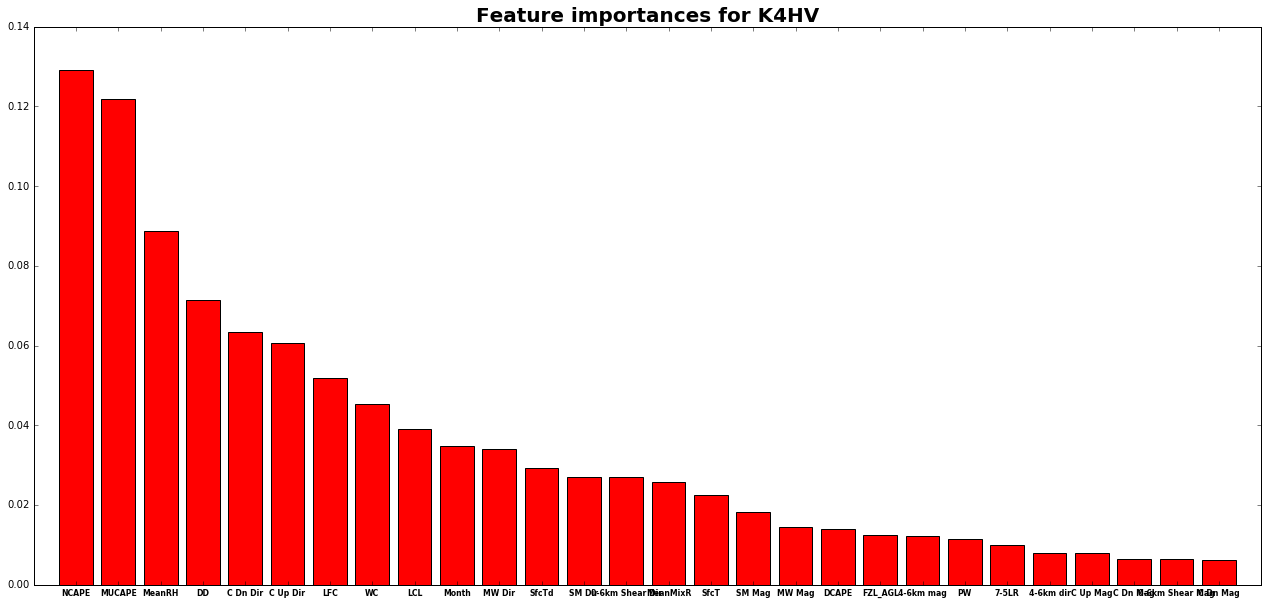

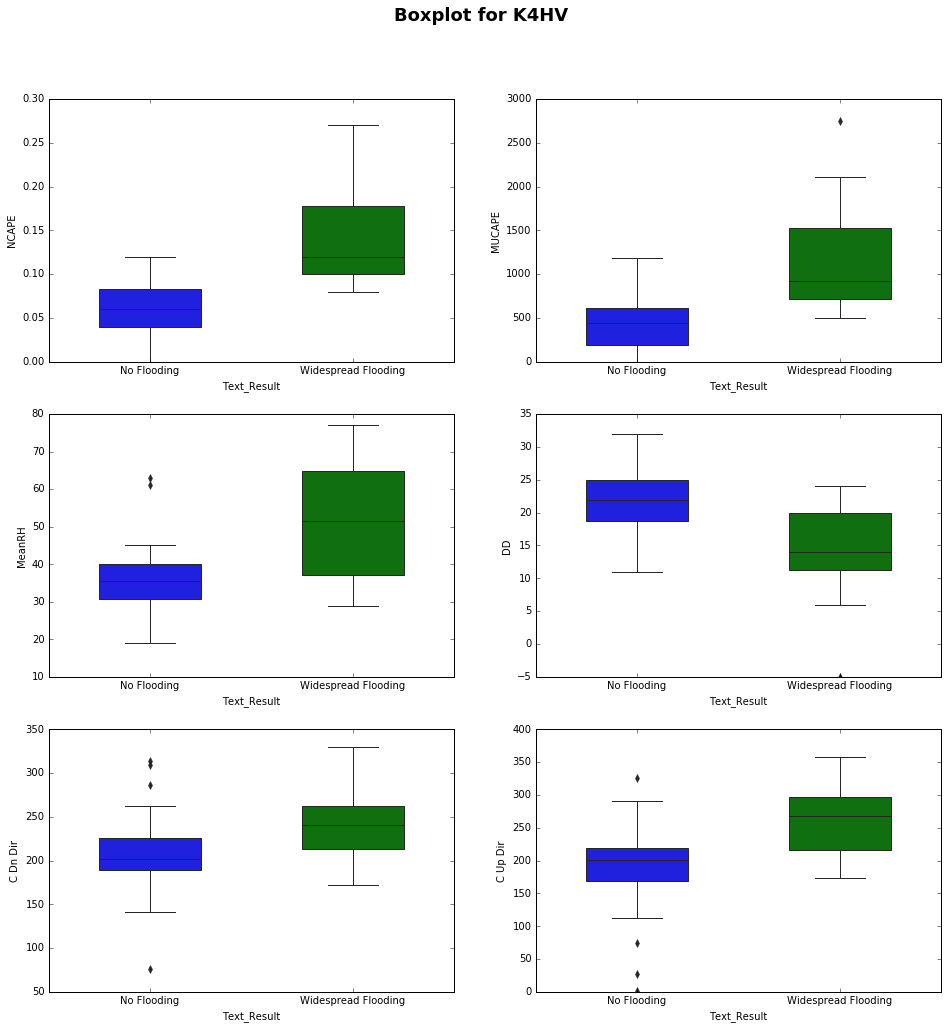

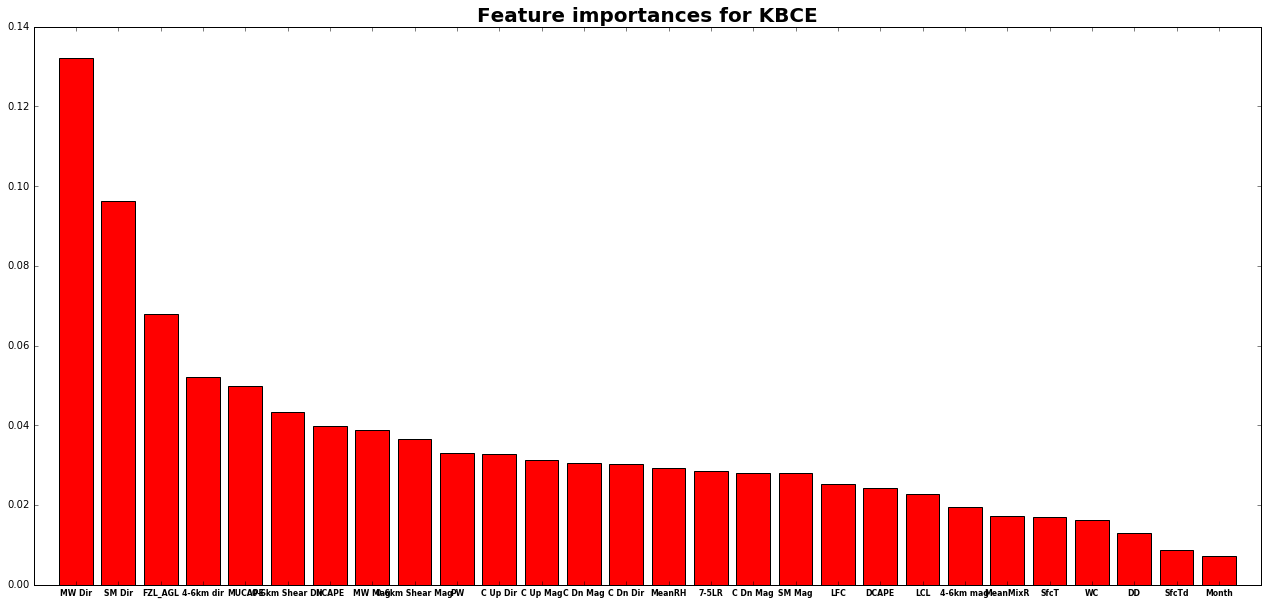

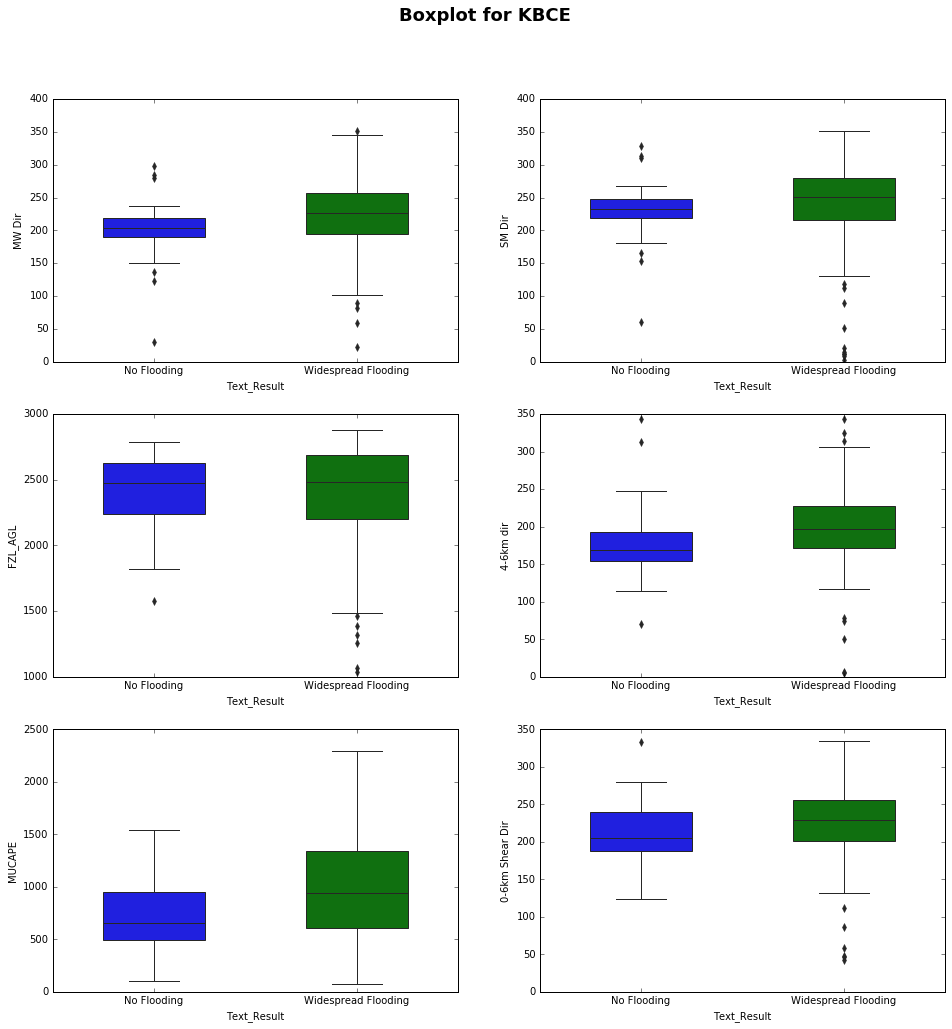

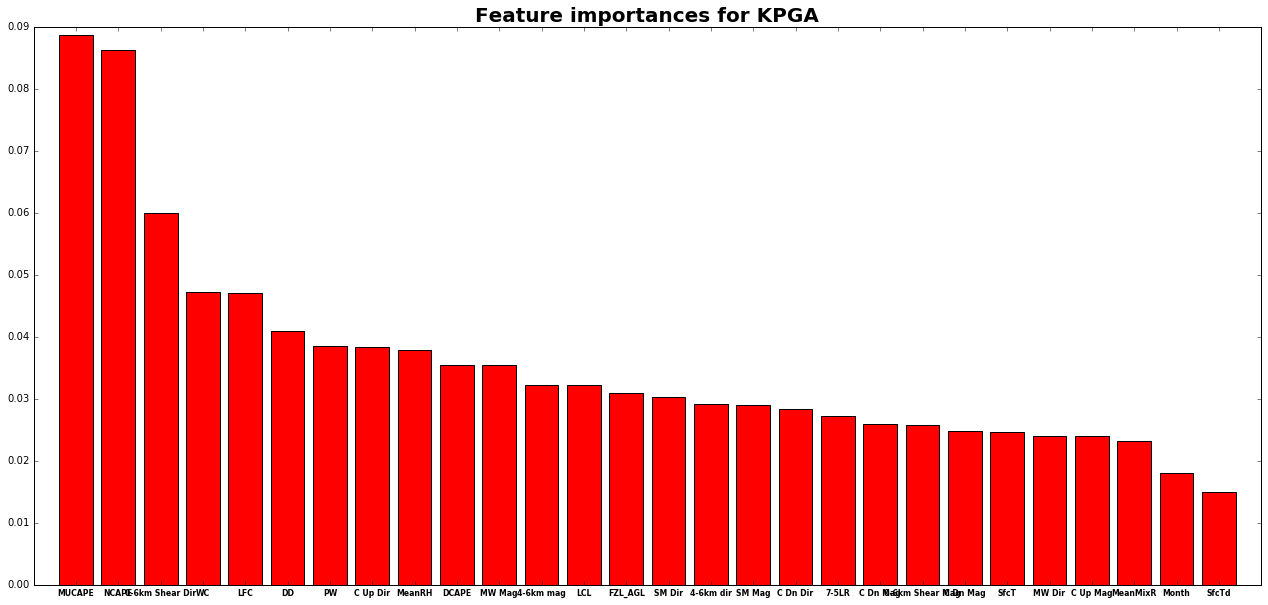

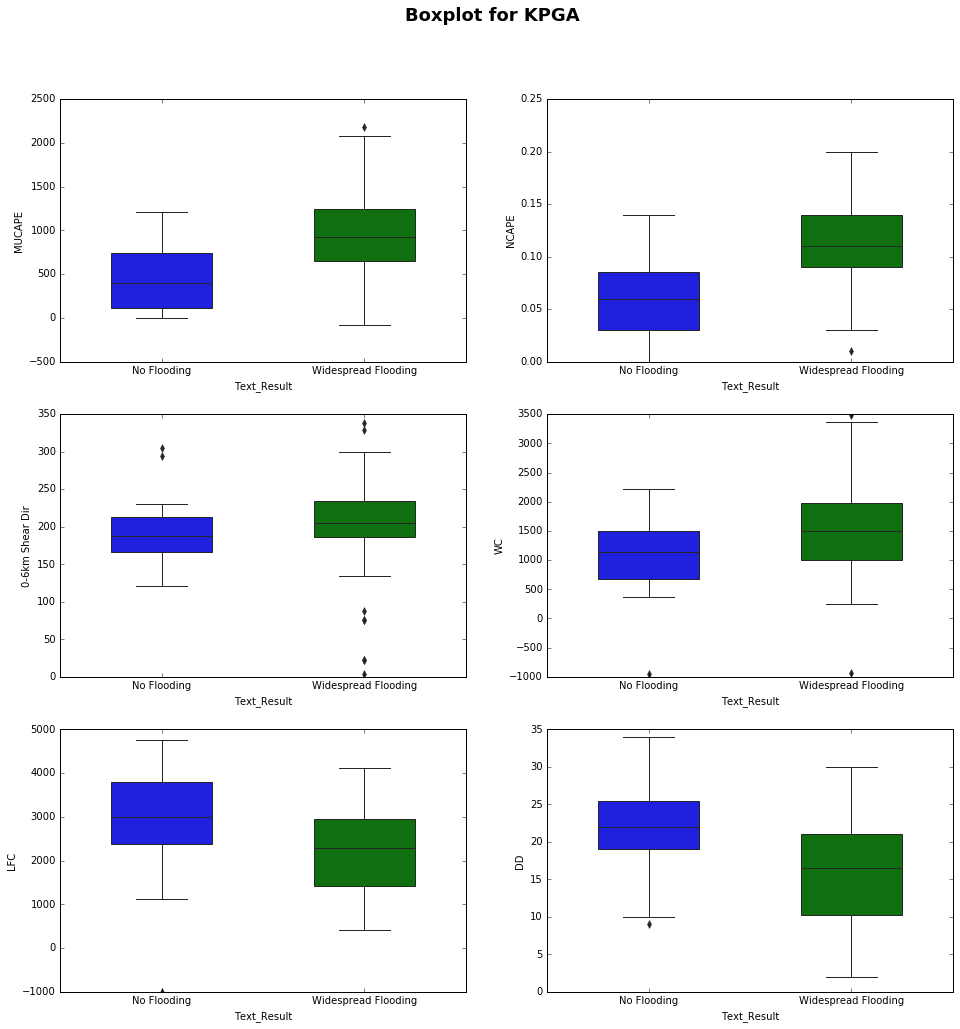

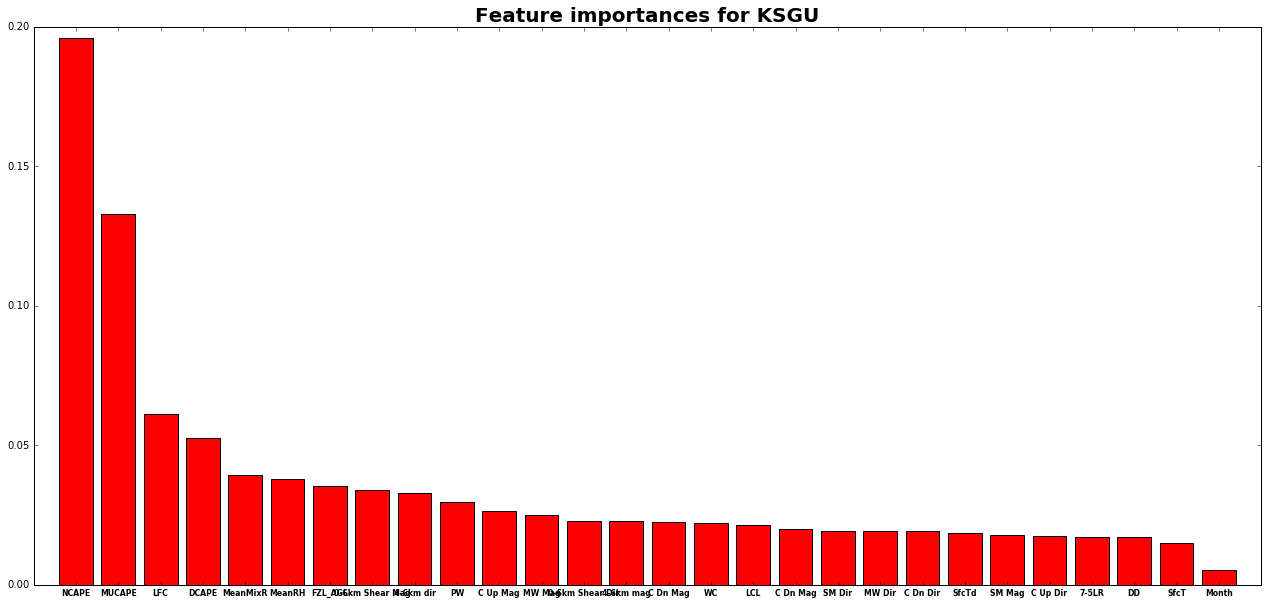

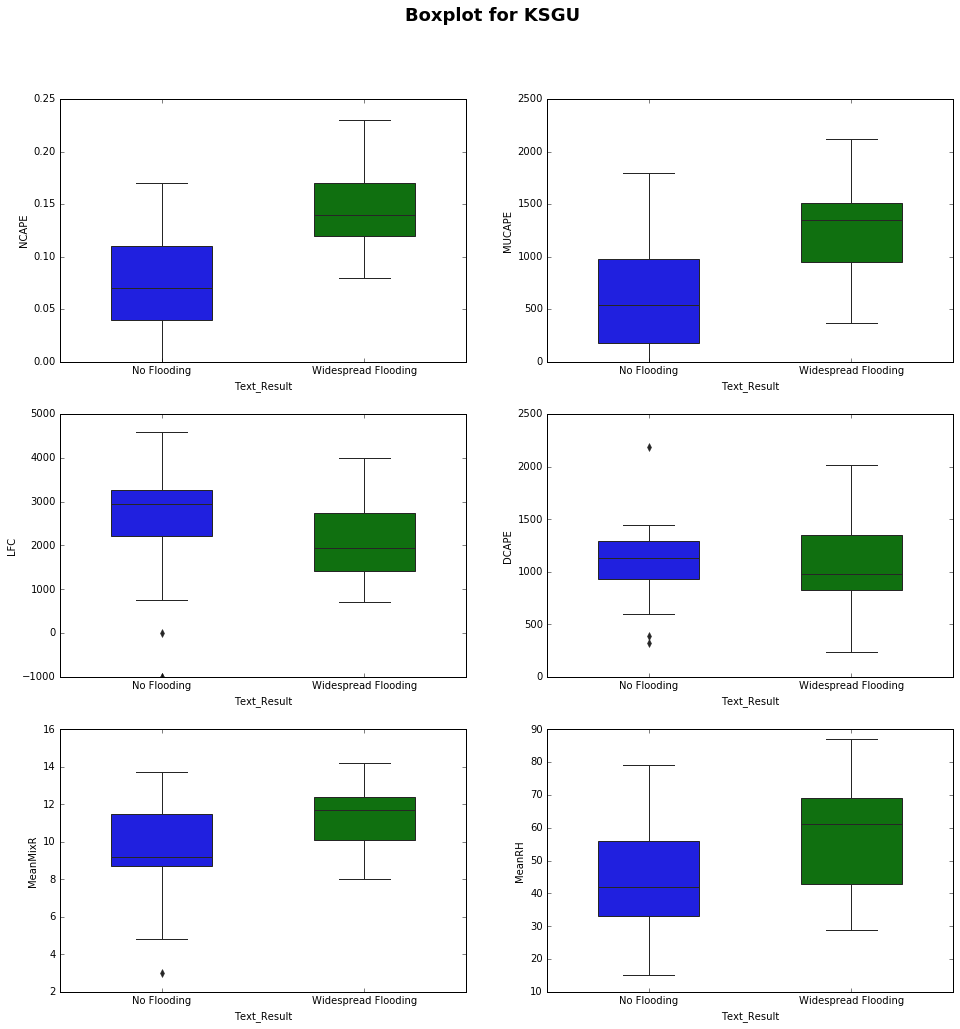

In [4]:
THERMO = ['MUCAPE', 'NCAPE', 'DCAPE', 'LCL',
          'PW', '7-5LR', 'MeanRH', 'SfcT', 'SfcTd',
          'DD', 'FZL_AGL', 'WC', 'MeanMixR', 'LFC'] 

#Kinematic variables
KIN = ['0-6km Shear Dir', '0-6km Shear Mag', 'C Dn Dir',
       'C Dn Mag', 'C Up Dir', 'C Up Mag', 'SM Dir',
       'C Dn Mag', 'MW Dir', 'MW Mag', 'SM Mag', '4-6km dir',
       '4-6km mag', 'Month']

for csv in glob.glob("*clean.csv"):
    site_name = csv[:4]
    df = pd.read_csv(csv)
    #df.loc[(df['Basins'] == 2), 'Result'] = 1
    #df.loc[(df['Basins'] == 1), 'Result'] = np.nan
    df.dropna(subset=KIN + THERMO + ['Result'], inplace=True) 
    predictors = df[THERMO + KIN]
    result = df['Result']
    
    xtrain, xtest, ytrain, ytest = train_test_split(predictors, 
                                                    result, 
                                                    test_size= 0.30) 
    #Hyperparameters based on tuning
    clf = ens.RandomForestClassifier(n_estimators=1000, max_depth=10, min_samples_leaf=2,
                                     min_samples_split=2,oob_score=True,
                                     class_weight='balanced')
    clf.fit(xtrain, ytrain)
    y_pred = clf.predict(xtest)
    accuracy = metrics.accuracy_score(ytest, y_pred)
    internal_score = 1 - clf.oob_score_
    yprob = clf.predict_proba(xtest)[0:, 1]
    brier_score = metrics.brier_score_loss(ytest, yprob)
    feature_imp = pd.Series(clf.feature_importances_,
                            index=predictors.columns).sort_values(ascending=False)
    cm = metrics.confusion_matrix(ytest, y_pred)
    index_names = ['No Flooding Observed', 'Flooding Observed']
    col_names = ['No Flooding Forecast', 'Flooding Forecast']
    cm_df = pd.DataFrame(cm, columns =col_names, index=index_names)
    print (site_name, 'Accuracy = {:3.2f}, '.format(accuracy) + 
           ' Brier Score {:3.2f}, '.format(brier_score) + 
           'Out of bag error score {:3.2f}'.format(internal_score))
    display(cm_df.head())
    importance_plot(predictors, feature_imp, site_name)
    boxplot(df, feature_imp, site_name)
    print '------------------------------------ \n'
    

<b> Bryce essentially is overpredicting flooding likely due to the high ratio of flooding cases relative to null cases... if we balance the dataset a bit by requiring 3 Basins for Bryce to be flooding does it change the result?

The answer is yes our dataset appears to be more balanced, feature importances change a little only considering 3+ Basins although the directions still dominate the top features </b>

('KBCE', 'Accuracy = 0.70,  Brier Score 0.19, Out of bag error score 0.37')


,No Flooding Forecast,Flooding Forecast
No Flooding Observed,5,4
Flooding Observed,6,18


------------------------------------ 



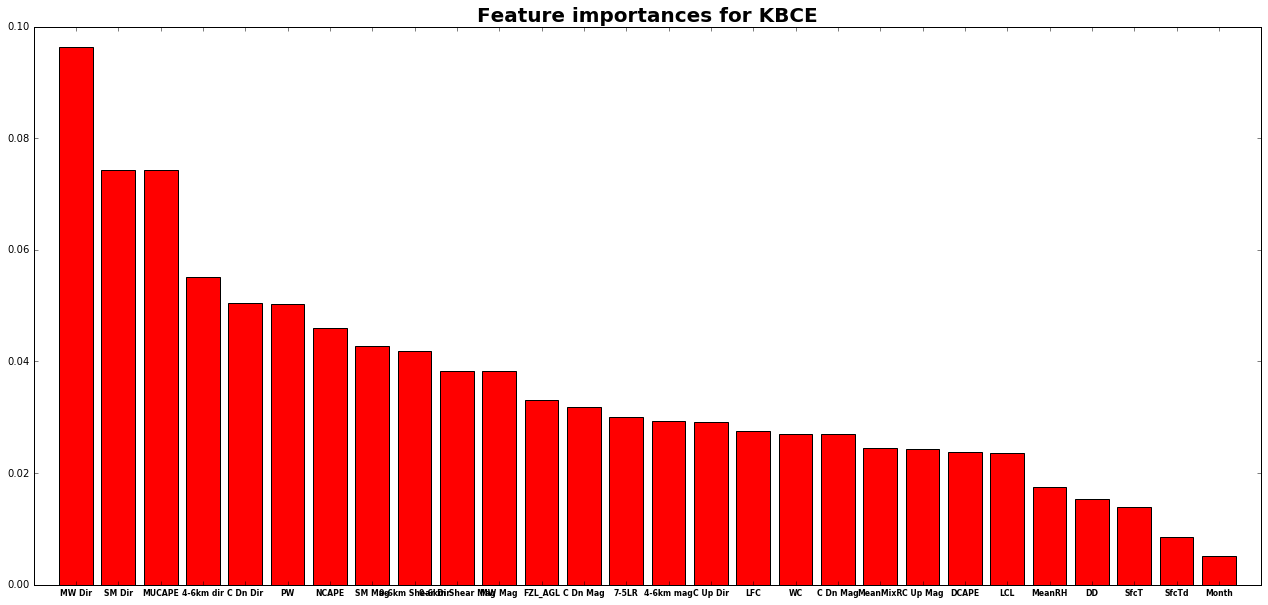

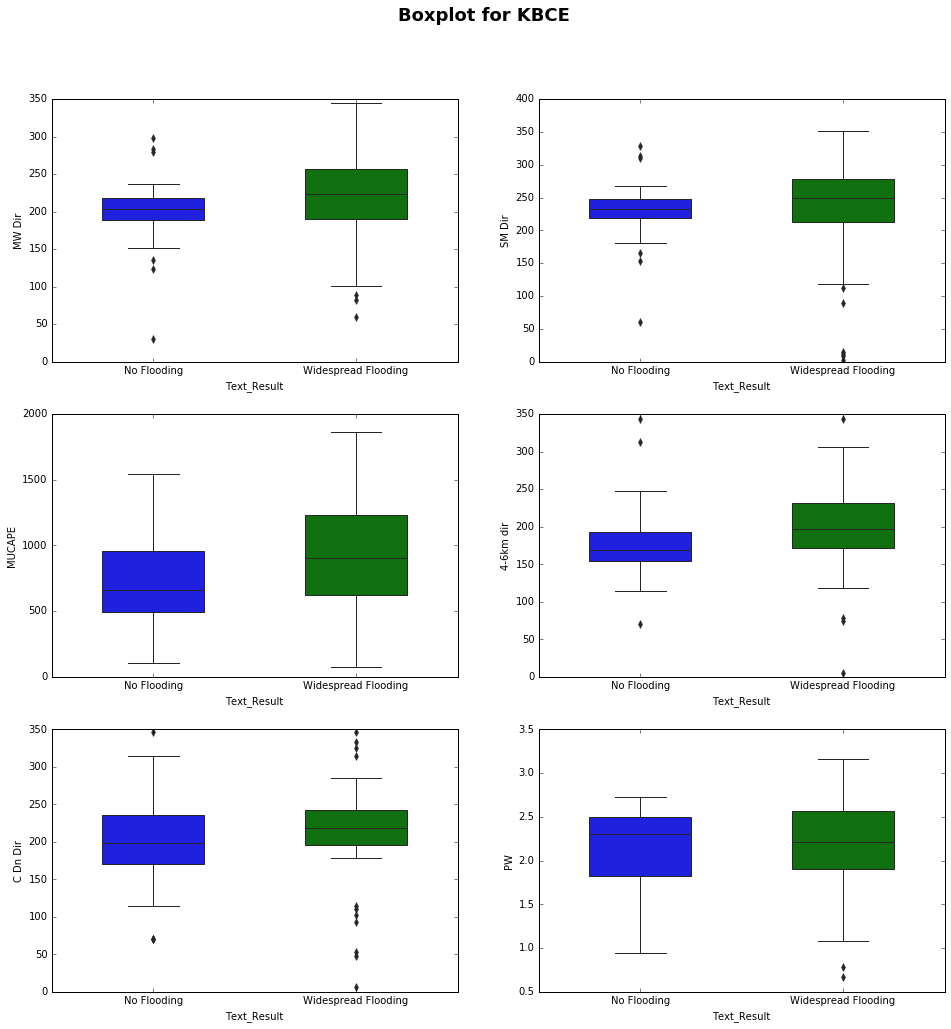

In [10]:

df = pd.read_csv('KBCE_clean.csv')
site_name = 'KBCE'
df.loc[(df['Basins'] == 2), 'Result'] = np.nan #Require 3 Basins 

df.dropna(subset=KIN + THERMO + ['Result'], inplace=True) 
predictors = df[THERMO + KIN]
result = df['Result']
    
xtrain, xtest, ytrain, ytest = train_test_split(predictors, 
                                                result, 
                                                test_size= 0.30) 
#Hyperparameters based on tuning
clf = ens.RandomForestClassifier(n_estimators=1000, max_depth=10, min_samples_leaf=2,
                                 min_samples_split=2,oob_score=True,
                                 class_weight='balanced')
clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)
accuracy = metrics.accuracy_score(ytest, y_pred)
internal_score = 1 - clf.oob_score_
yprob = clf.predict_proba(xtest)[0:, 1]
brier_score = metrics.brier_score_loss(ytest, yprob)
feature_imp = pd.Series(clf.feature_importances_,
                        index=predictors.columns).sort_values(ascending=False)
cm = metrics.confusion_matrix(ytest, y_pred)
index_names = ['No Flooding Observed', 'Flooding Observed']
col_names = ['No Flooding Forecast', 'Flooding Forecast']
cm_df = pd.DataFrame(cm, columns =col_names, index=index_names)
print (site_name, 'Accuracy = {:3.2f}, '.format(accuracy) + 
       ' Brier Score {:3.2f}, '.format(brier_score) + 
       'Out of bag error score {:3.2f}'.format(internal_score))
display(cm_df.head())
importance_plot(predictors, feature_imp, site_name)
boxplot(df, feature_imp, site_name)
print '------------------------------------ \n'